In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from modules import *

In [3]:
torch.cuda.is_available()

True

In [4]:
config = Config('config-Copy5.json')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
config[...]

{'name': 'simple_linear',
 'batchsize': 256,
 'epoch': {'start': 1, 'end': 99999},
 'lr': {'initial': 0.001,
  'decay_rate': 0.99,
  'decay_step': 1,
  'override': None},
 'log_period': 1,
 'test': {'name': 'simple_linear', 'epoch': 122, 'out_prefix': 'lin'}}

In [7]:
class Net_SimpleLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        edge_feats = 2
        
        self.conv1 = NNConv(2, 128, nn.Linear(edge_feats, 2*128), aggr='mean')
        self.conv2 = NNConv(128, 2, nn.Linear(edge_feats, 2*128), aggr='mean')

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = self.conv1(x, edge_index, edge_attr)
        x2 = self.conv2(x1, edge_index, edge_attr)
        
        return x2

In [8]:
def load_processed_data():
    if os.path.isfile('G_list.pickle') and os.path.isfile('data_list.pickle'):
        G_list = pickle.load(open('G_list.pickle', 'rb'))
        data_list = pickle.load(open('data_list.pickle', 'rb'))
    else:
        if not os.path.isfile('data_index.txt'):
            shuffle_rome('data_index.txt')
        rome = load_rome('data_index.txt')
        G_list, data_list = convert_datalist(rome)
        pickle.dump(G_list, open('G_list.pickle', 'wb'))
        pickle.dump(data_list, open('data_list.pickle', 'wb'))
    return G_list, data_list

In [9]:
G_list, data_list = load_processed_data()

In [21]:
loader = DataLoader(data_list[:10000], batch_size=config['batchsize'],shuffle=True)
loss_ep = []

In [22]:
start_epoch = config['epoch']['start']
if start_epoch == 1:
    model = Net_SimpleLinear().to(device)
else:
    model = torch.load(f"../ckpt_{config['name']}/epoch_{start_epoch}.pt").to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['initial'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=config['lr']['decay_step'], 
                                            gamma=config['lr']['decay_rate'])
print("=" * 50, file=open(f"{config['name']}.log", "a"))
epoch = start_epoch
while True:
    if config['lr']['override'] is not None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['override'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                    step_size=config['lr']['decay_step'], 
                                                    gamma=config['lr']['decay_rate'])
    loss = train(model, criterion, optimizer, loader, data_list, device)
    loss_ep.append(loss)
    scheduler.step()
    if epoch == 1:
        print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
    if epoch % config['log_period'] == 0:
        torch.save(model, f"../ckpt_{config['name']}/epoch_{epoch}.pt")
        print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
    if epoch == config['epoch']['end']:
        break
    epoch += 1

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net_SimpleLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

# Performance Testing

In [10]:
model = torch.load(f'../ckpt_{config["test"]["name"]}/epoch_{config["test"]["epoch"]}.pt').to(device)
criterion = EnergyLossVectorized()
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
folder_name = f'{config["test"]["name"]}_test'
for test_idx in tqdm(list(chain(range(0, 10000, 10), range(10000, len(G_list))))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_model_{test_idx}_{loss}.png') 
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')

In [ ]:
losses = []
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    losses += [loss]

In [ ]:
np.mean(losses), np.std(losses)

1000

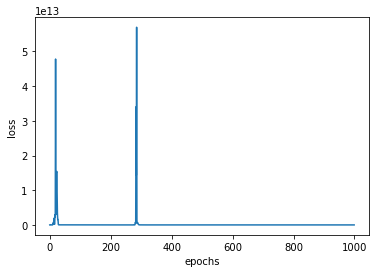

In [174]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

tensor([[0.4000, 0.2500, 2.0000],
        [1.2000, 0.0278, 2.0000],
        [0.8000, 0.0625, 2.0000],
        ...,
        [0.6000, 0.1111, 3.0000],
        [1.0000, 0.0400, 3.0000],
        [1.2000, 0.0278, 3.0000]])